In [1]:
import signac as sg
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import gamma
from scipy.optimize import curve_fit

In [2]:
project = sg.get_project()
with sg.H5Store('shared_data.h5').open(mode='r') as sd:
    b_vec = np.array(sd['b_vec'])
c = 1.42

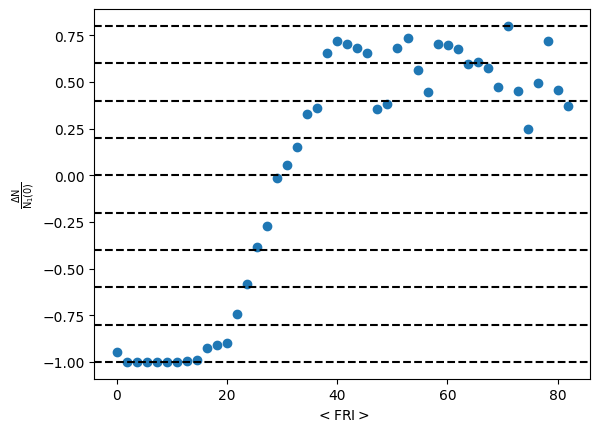

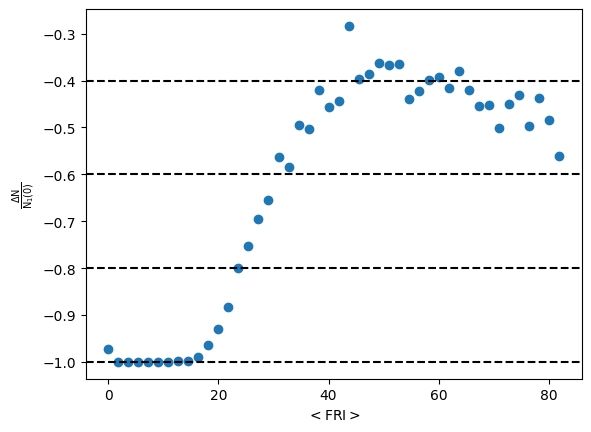

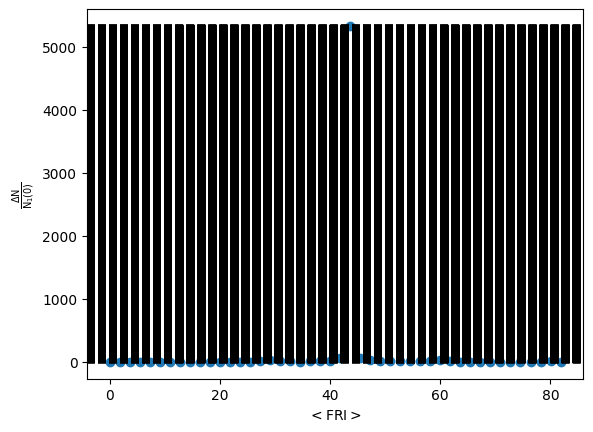

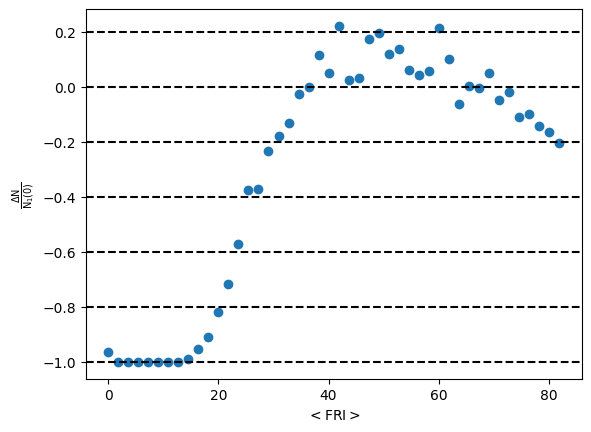

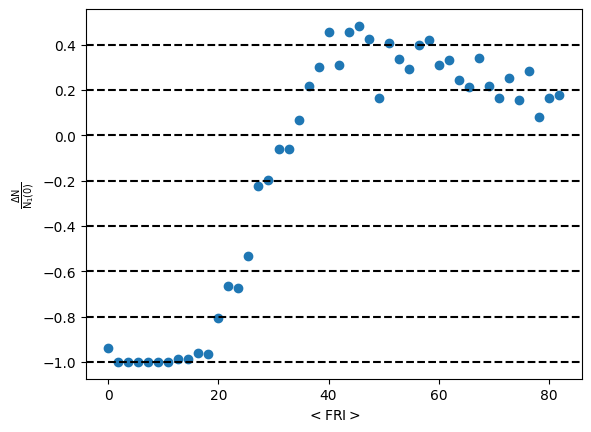

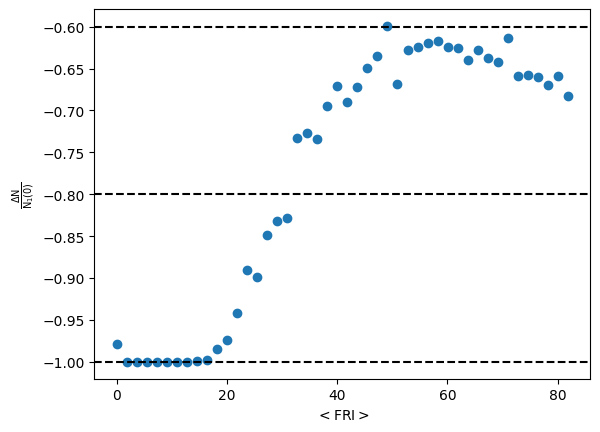

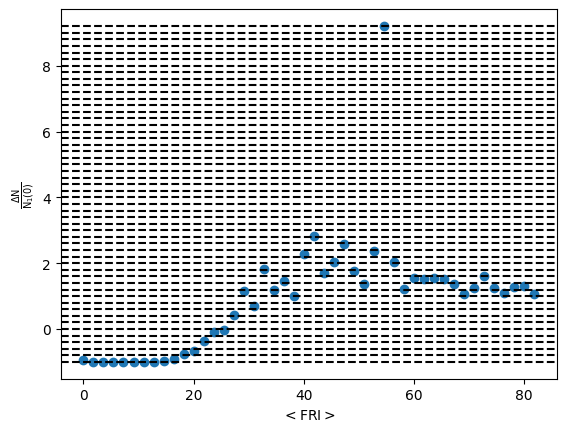

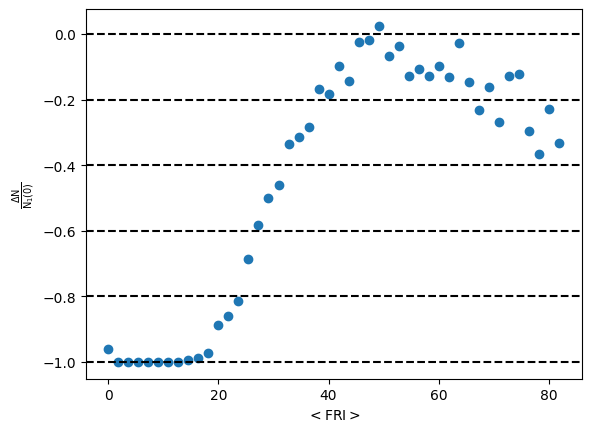

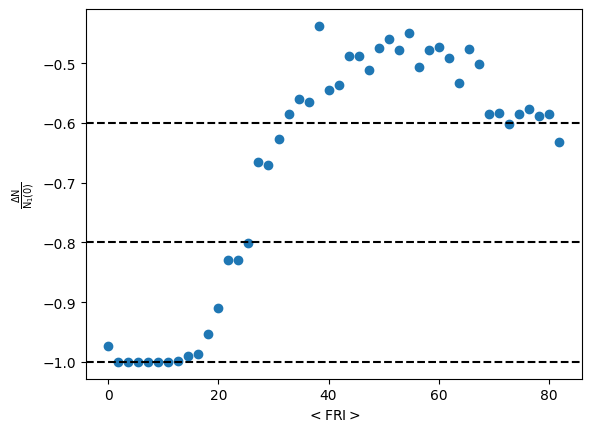

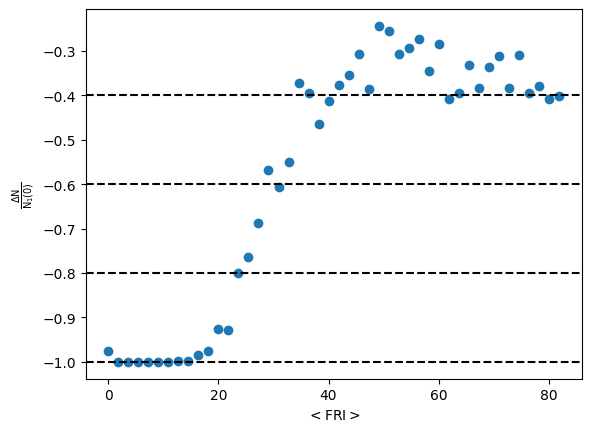

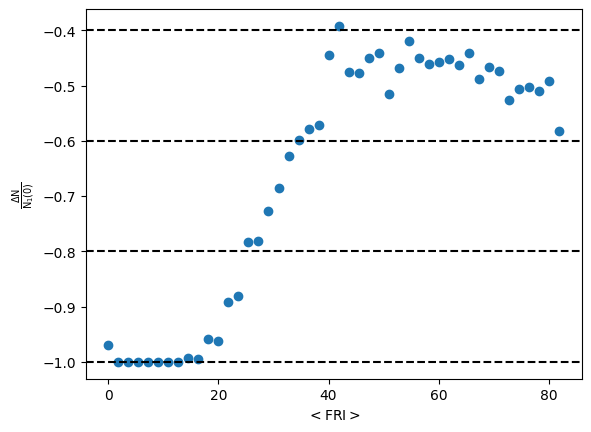

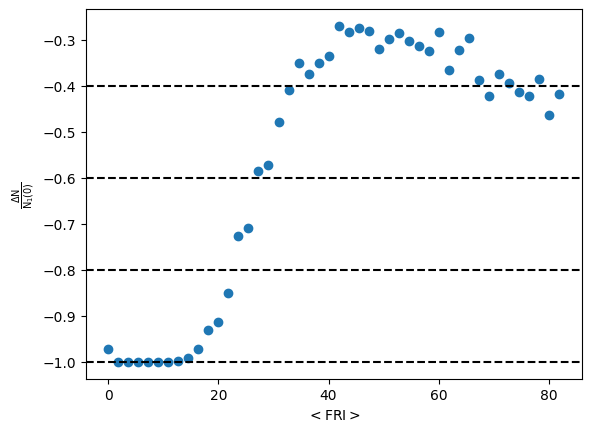

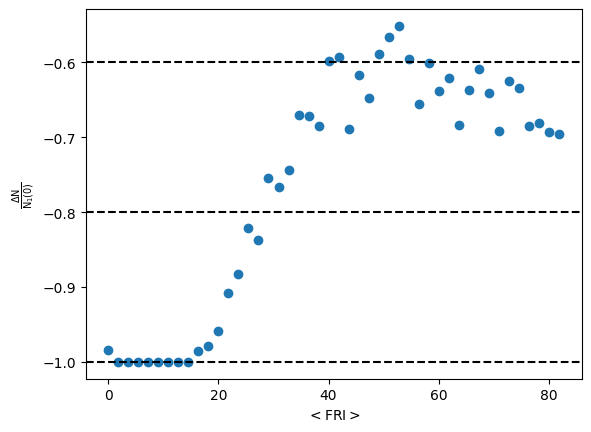

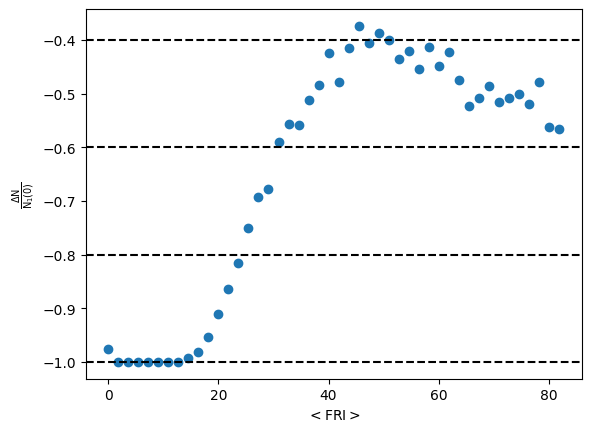

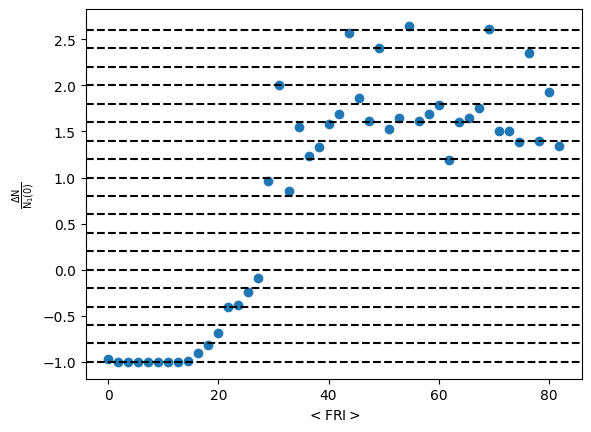

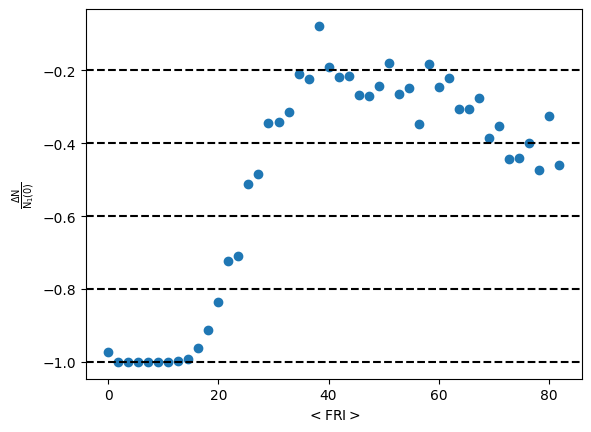

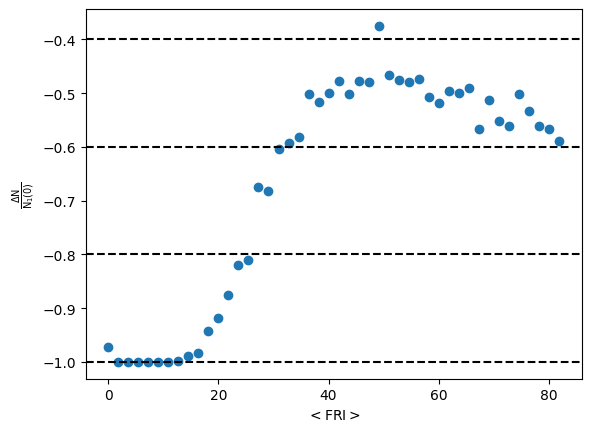

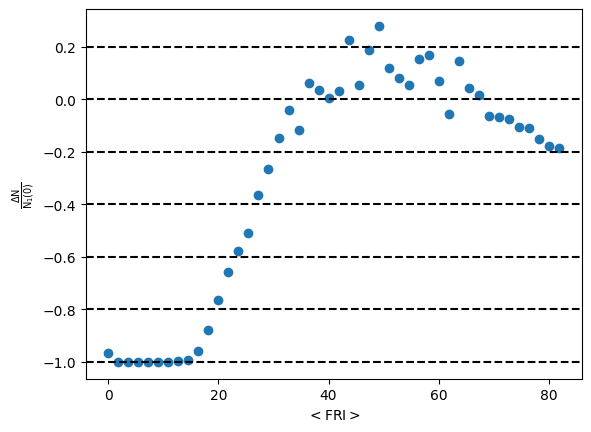

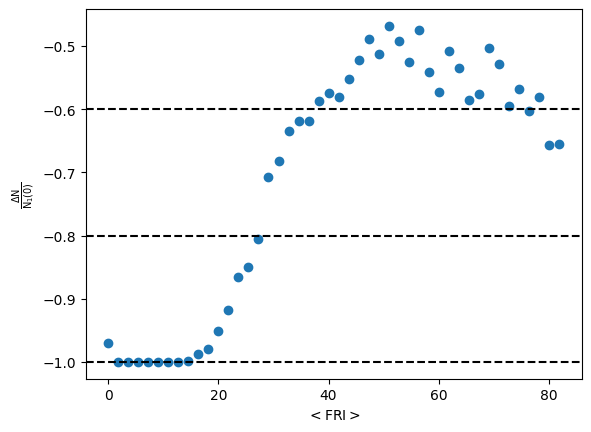

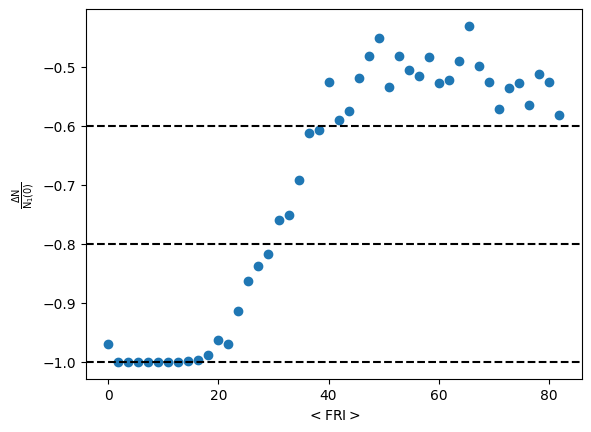

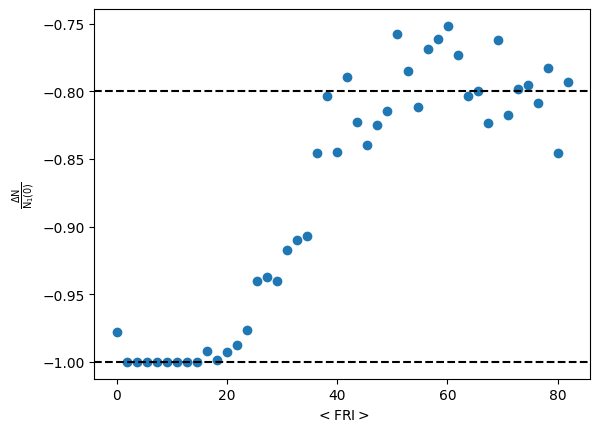

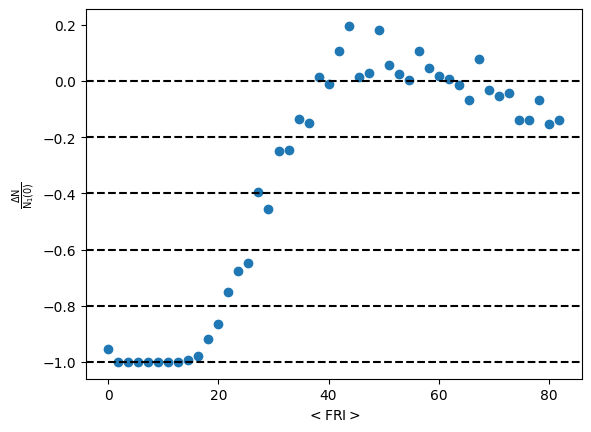

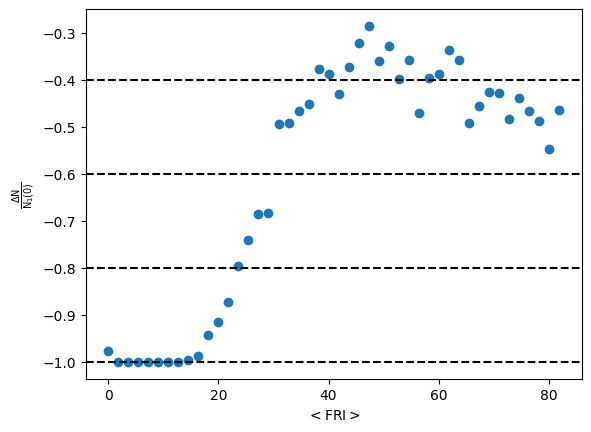

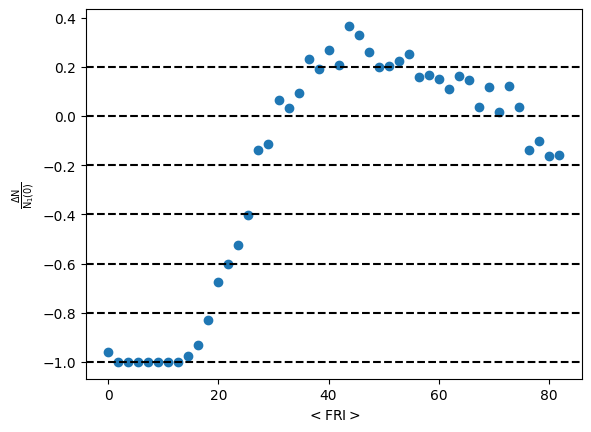

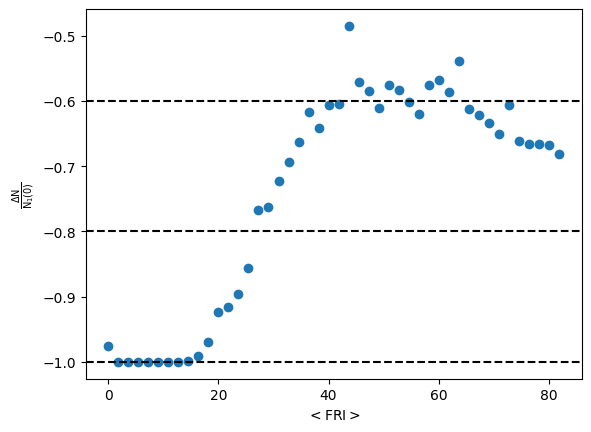

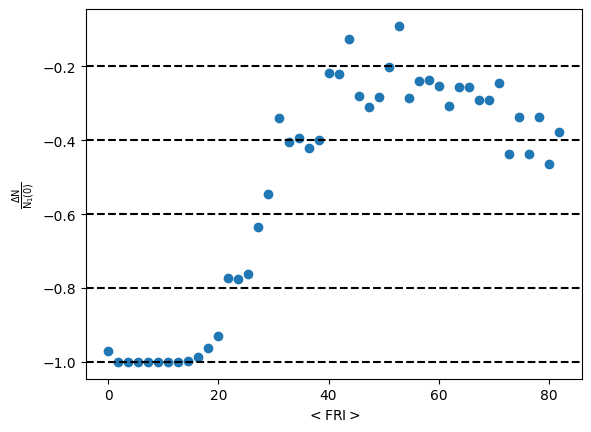

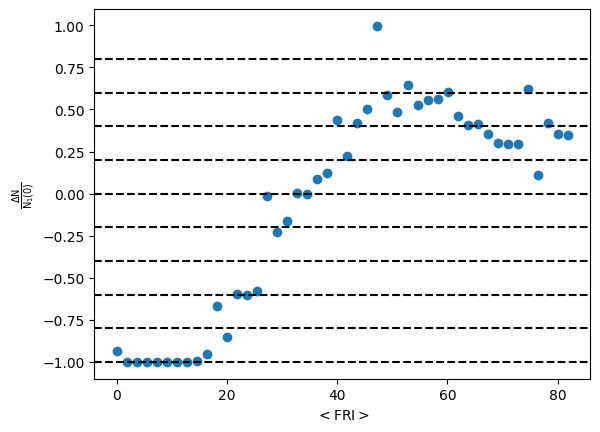

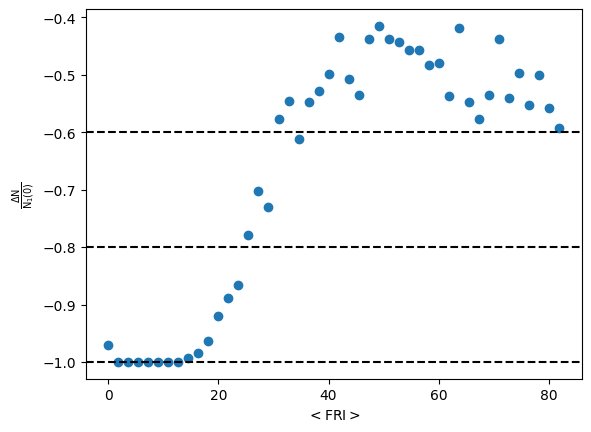

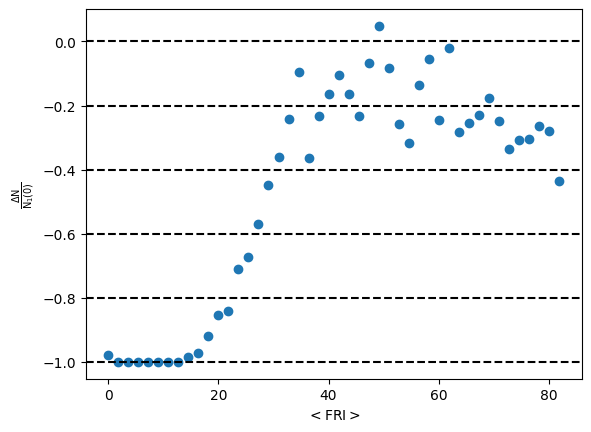

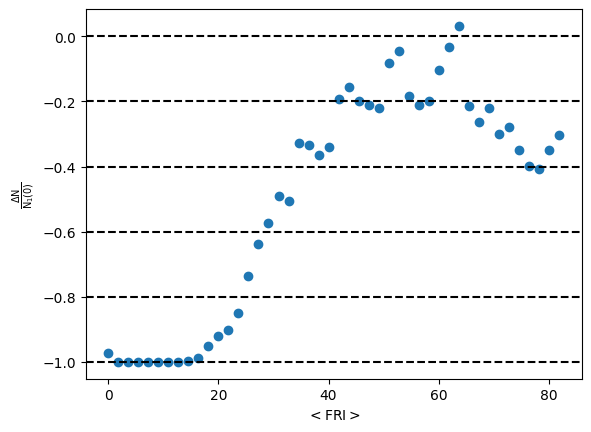

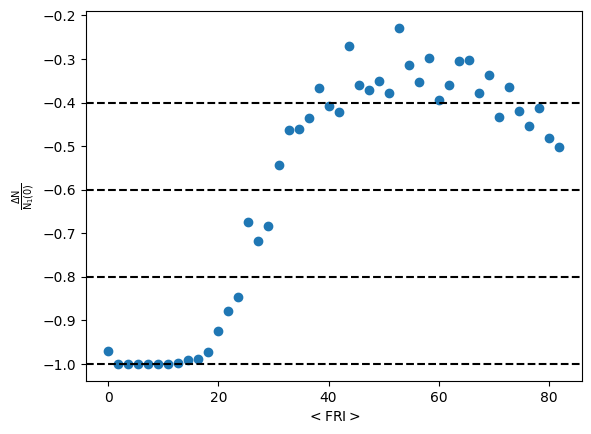

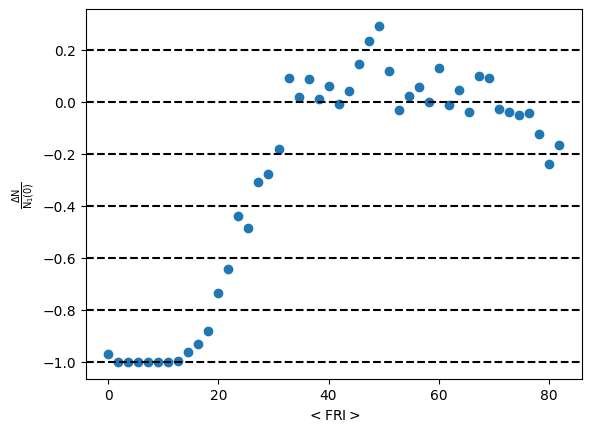

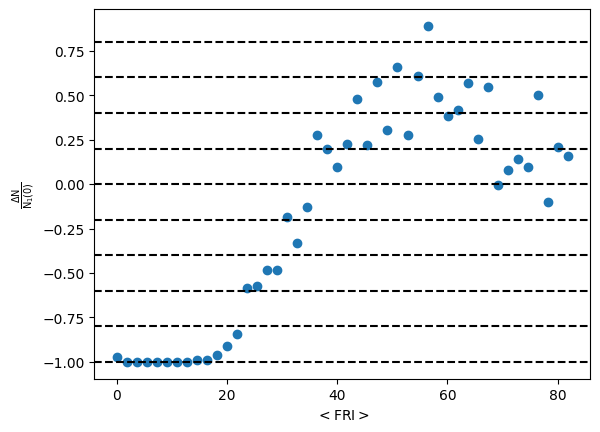

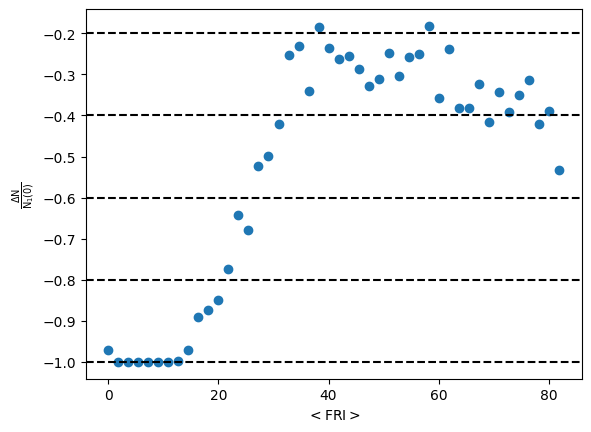

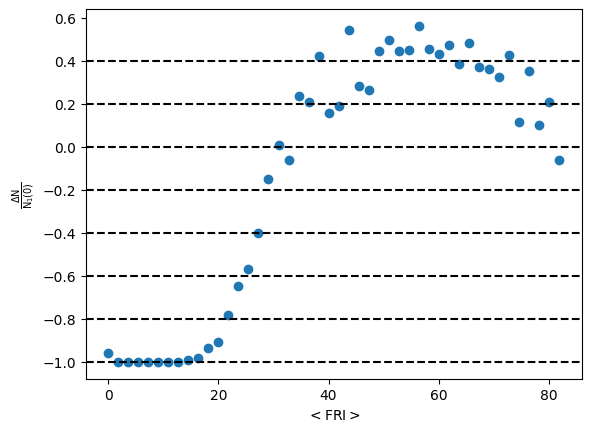

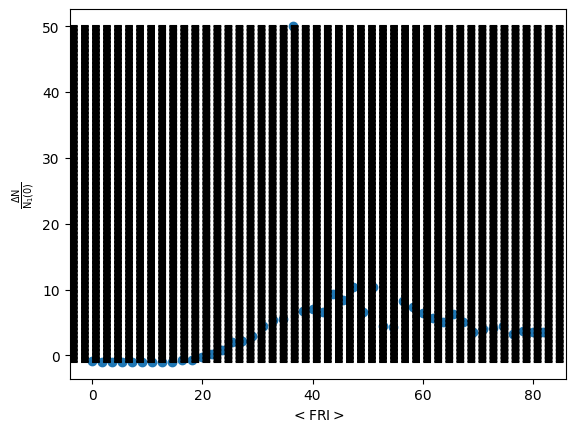

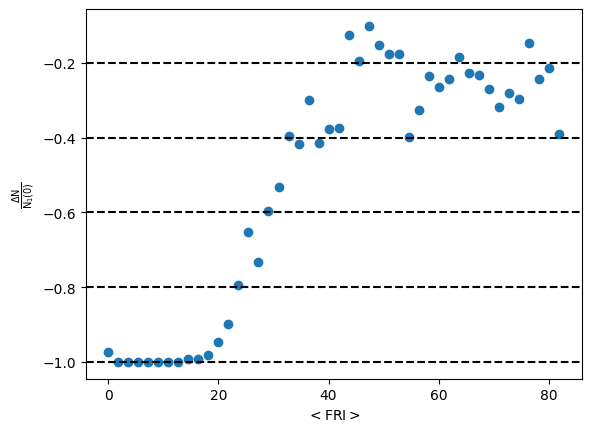

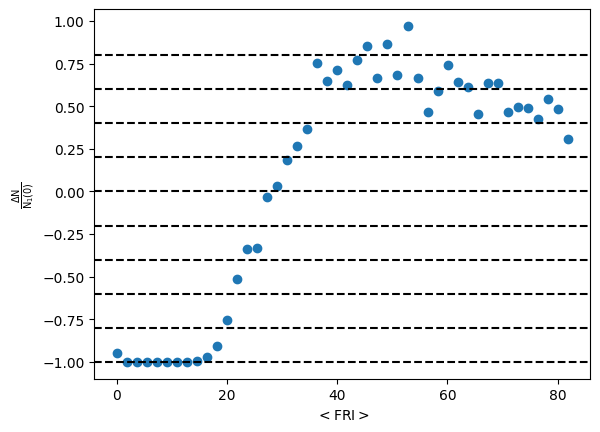

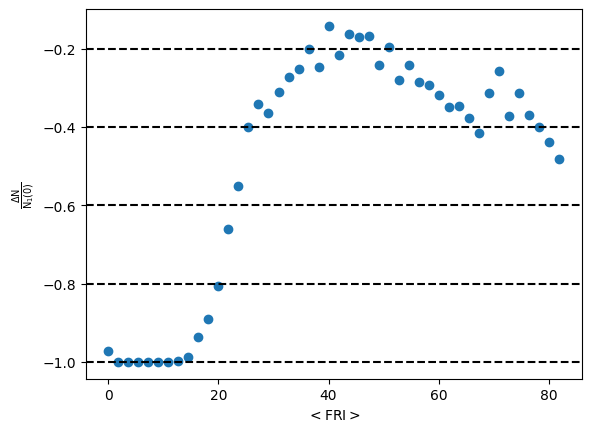

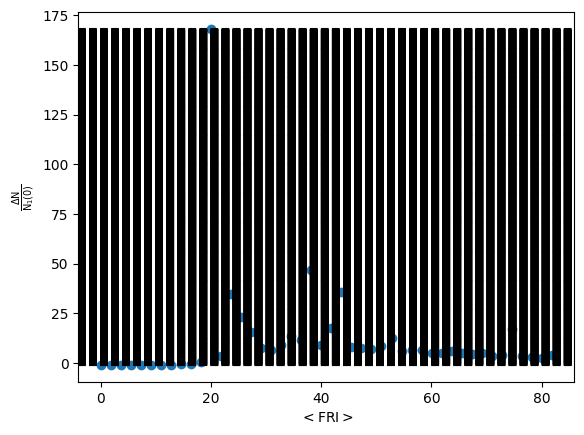

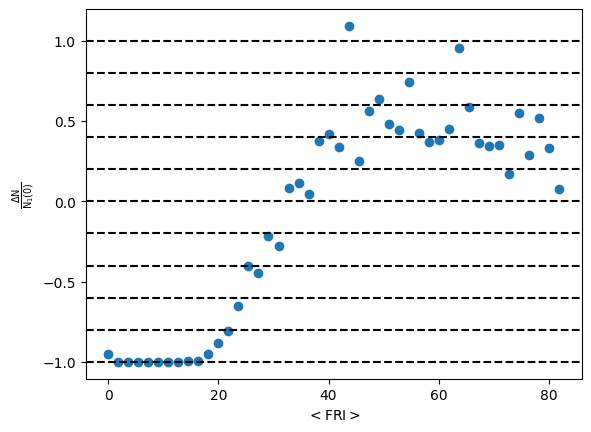

In [23]:
for job_i, job in enumerate(project.find_jobs({'doc.simulated': True})):
    # print(job.id)
    # if job.id == '517b1eabc6e9124a323284f568a9d5c2': continue
    if job_i > 40: continue
    with job.data as data:
        fri_vec = []
        frac_change_vec = []
        extir_rate_vec = []
        for b in b_vec:
            fri_vec.append(b * gamma(1+1/c))
            frac_change_vec.append(float(data['fractional_change/{}'.format(b)]))
            # extir_rate_vec.append(float(data['extirpation_rate/{}'.format(b)]))
    plt.scatter(fri_vec, frac_change_vec)
    plt.ylabel(r'$\frac{\Delta \text{N}}{\text{N}_1(0)}$')
    plt.xlabel(r'$<\text{FRI}>$')
    for y in np.arange(-1,max(frac_change_vec), 0.2):
        plt.axhline(y, ls='--', c='k')
    plt.show()
    # plt.scatter(fri_vec, extir_rate_vec)
    # plt.ylabel('extirpation rate')
    # plt.xlabel(r'$<\text{FRI}>$')
    # plt.show()

In [3]:
fri_vec = b_vec * gamma(1+1/c)
fri_step = (b_vec[1]-b_vec[0]) * gamma(1+1/c)
bw = 0.2
bin_edges = np.arange(-1, 6+bw, bw)
metric_labels = ['bin_robustness']
metric_data = {lab: [[] for _bin in range(len(bin_edges))] for lab in metric_labels}
jobs = project.find_jobs({'doc.simulated': True})
# for job in project.find_jobs({'doc.simulated': True}):
for job in jobs:
    r_vec = np.ones(len(b_vec))*np.nan
    with job.data as data:
        for b_i, b in enumerate(b_vec):
            r_vec[b_i] = float(data['fractional_change/{}'.format(b)])
    for bin_i, left in enumerate(bin_edges):
        within = np.nonzero((r_vec >= left) & (r_vec < left+bw))[0]
        bin_robustness = len(within) * fri_step
        metric_data['bin_robustness'][bin_i].append(bin_robustness)
    #     break
    # break

In [4]:
metric = 'bin_robustness'
# demo_samples = len(metric_data[metric][0])
demo_samples = len(jobs)

In [5]:
metric_max = max([max(data) for data in metric_data[metric]])

In [6]:
r_bin_cntrs = [np.mean(bin_edges[i:i+2]) for i in range(len(bin_edges)-1)]
r_bin_cntrs = np.array([np.round(v, decimals=1) for v in r_bin_cntrs])

In [39]:
metric_bw = 2
# metric_min = 1 / demo_samples
metric_min = 1
metric_bin_edges = np.concatenate(([metric_min], np.arange(metric_bw, metric_max+metric_bw, metric_bw)))
metric_bin_cntrs = np.array([np.mean(metric_bin_edges[i:i+2]) for i in range(len(metric_bin_edges)-1)])
res_mat = np.zeros((len(metric_bin_cntrs), len(bin_edges)))

In [40]:
for r_bin_i, r_left in enumerate(bin_edges):
    # print('response',r_left)
    for metric_bin_i, metric_left in enumerate(metric_bin_edges[:-1]):
        metric_right = metric_bin_edges[metric_bin_i+1]
        # print('metric',metric_left, metric_right)
        within = np.nonzero((metric_data[metric][r_bin_i] >= metric_left) & (metric_data[metric][r_bin_i] < metric_right))[0]
        # print(within)
        demo_count = len(within) / demo_samples
        # res_mat[len(metric_bin_edges)-1-metric_bin_i][r_bin_i] = demo_count
        res_mat[len(metric_bin_cntrs)-1-metric_bin_i][r_bin_i] = demo_count

Text(0.5, 0, '$\\frac{\\Delta \\text{N}}{\\text{N}_1(0)}$')

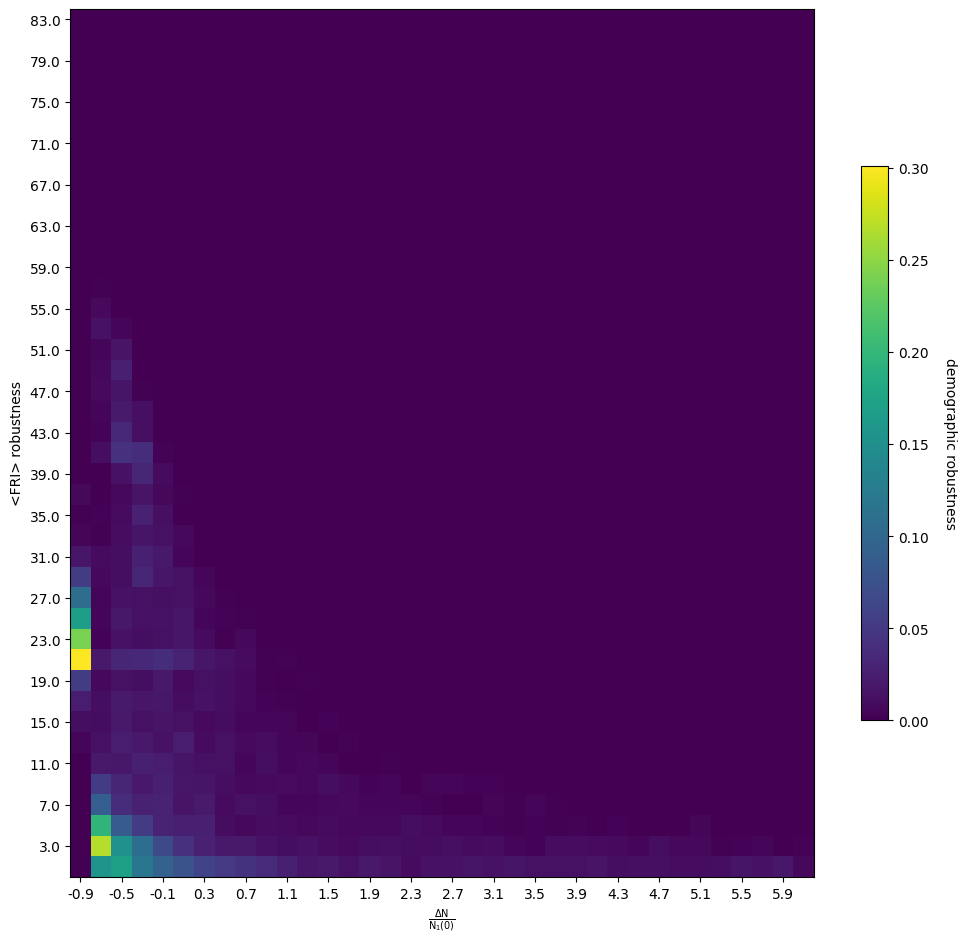

In [42]:
fig, ax = plt.subplots(figsize=(12,12))
im = ax.imshow(res_mat)
# im = ax.imshow(res_mat[10:][:])
cbar = ax.figure.colorbar(im, ax=ax, location="right", shrink=0.6)
cbar.ax.set_ylabel('demographic robustness', rotation=-90, fontsize=10, labelpad=20)
ax.set_yticks(np.arange(0,len(metric_bin_cntrs),2), labels=np.flip(metric_bin_cntrs)[::2]);
ax.set_ylabel('<FRI> robustness')
ax.set_xticks(np.arange(0,len(r_bin_cntrs),2), labels=r_bin_cntrs[::2]);
ax.set_xlabel(r'$\frac{\Delta \text{N}}{\text{N}_1(0)}$')
# ax.set_ylim(0,10)
fig.savefig('robustness.png', bbox_inches='tight;